In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display

openmeteo_csv = "kebithigollewa_openmeteo_solar_daily_2025_11.csv"
openmeteo_df = pd.read_csv(openmeteo_csv, parse_dates=["time"])

timeseries_csv = "timeseries_table_timeseries_table (4).csv"
radiation_df = pd.read_csv(timeseries_csv, sep=";")
radiation_df["time"] = pd.to_datetime(radiation_df["Timestamp"], format="%b %d %Y")
radiation_df = radiation_df.rename(columns={"Radiation": "radiation_observed"})[["time", "radiation_observed"]]

merged_df = openmeteo_df.merge(radiation_df, on="time", how="left")
merged_df.head()

,time,shortwave_radiation,direct_radiation,direct_normal_irradiance,diffuse_radiation,global_tilted_irradiance,radiation_observed
0,2025-11-01,6226.0,4667.0,7101.4,1559.0,6226.0,563.45
1,2025-11-02,6305.0,5179.0,7799.9,1126.0,6305.0,469.90
2,2025-11-03,6152.0,4848.0,7323.5,1304.0,6152.0,597.81
3,2025-11-04,6158.0,4869.0,7218.3,1289.0,6158.0,456.97
4,2025-11-05,5693.0,4121.0,5862.5,1572.0,5693.0,358.37


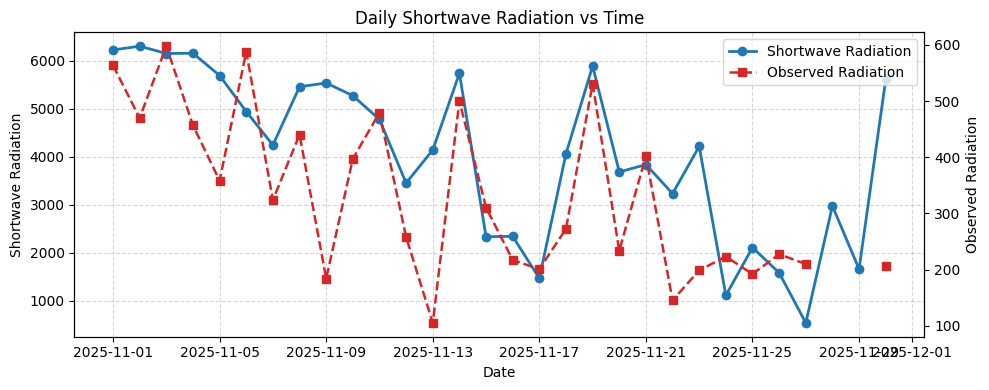

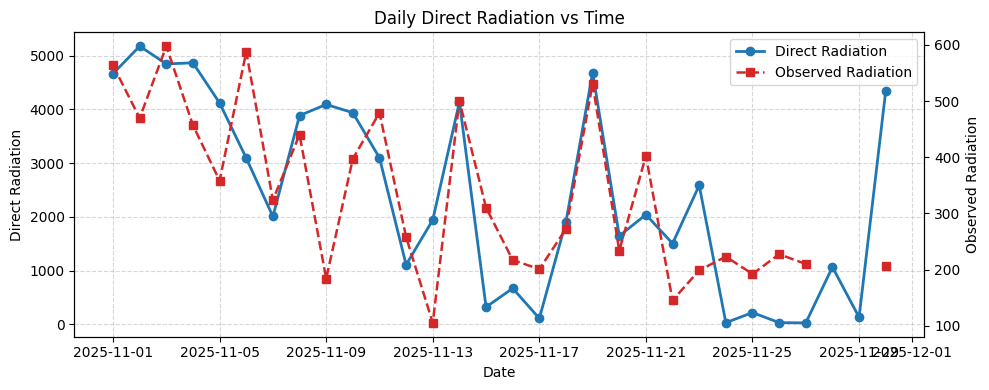

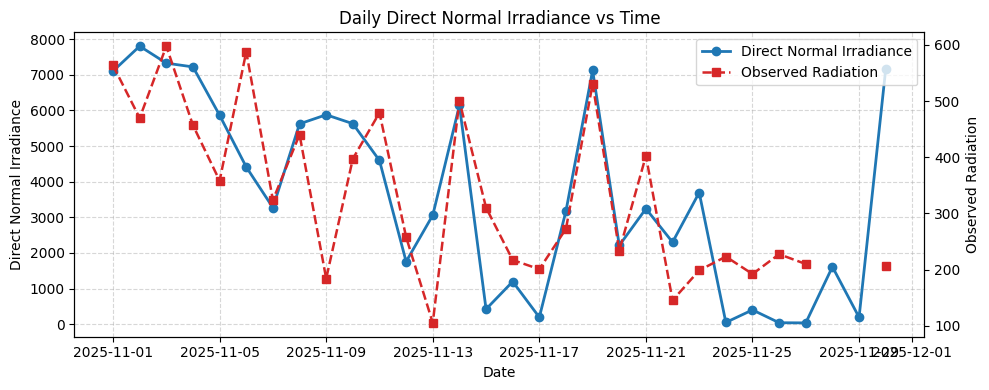

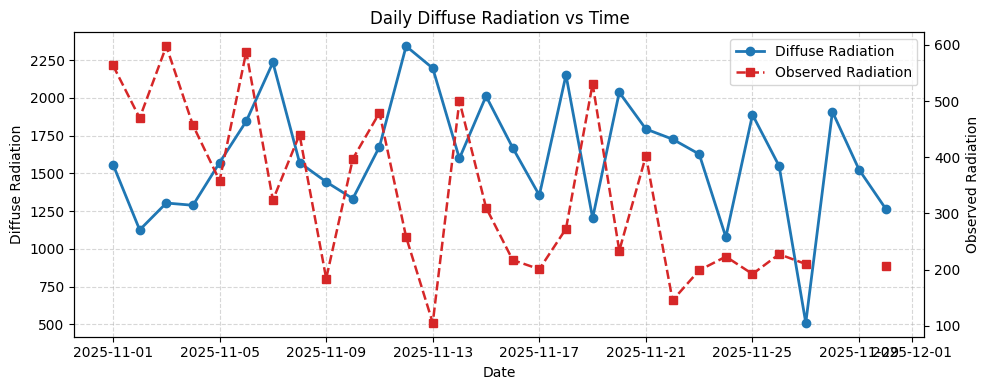

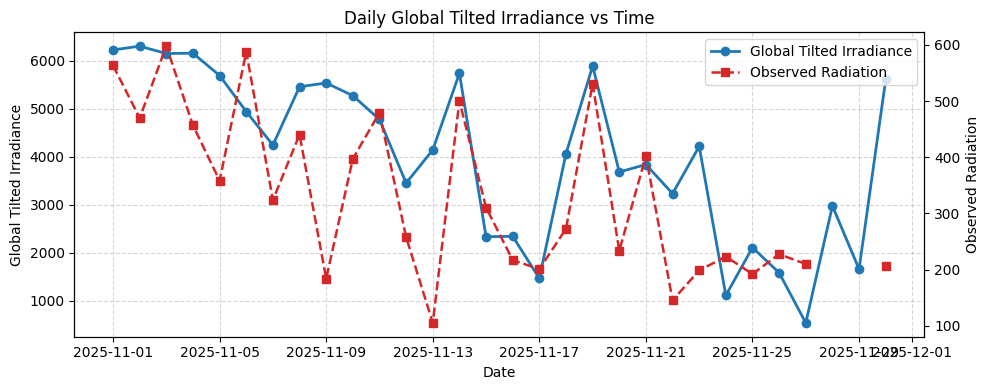

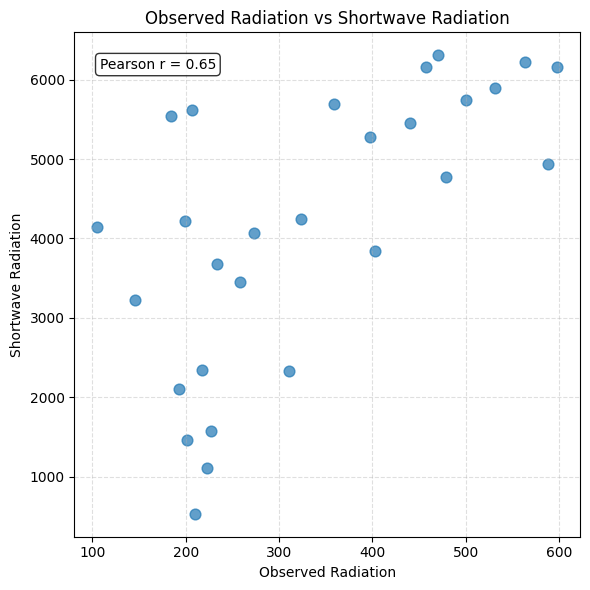

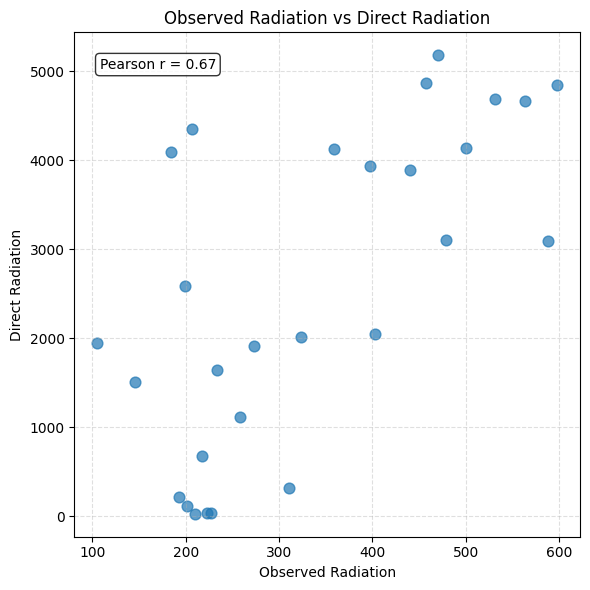

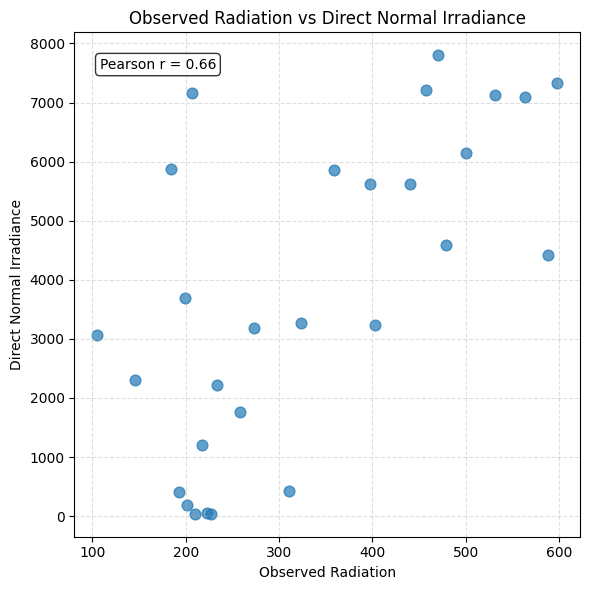

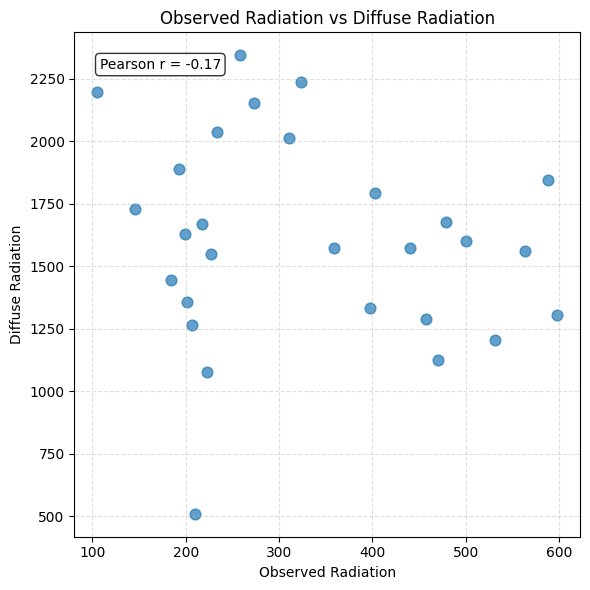

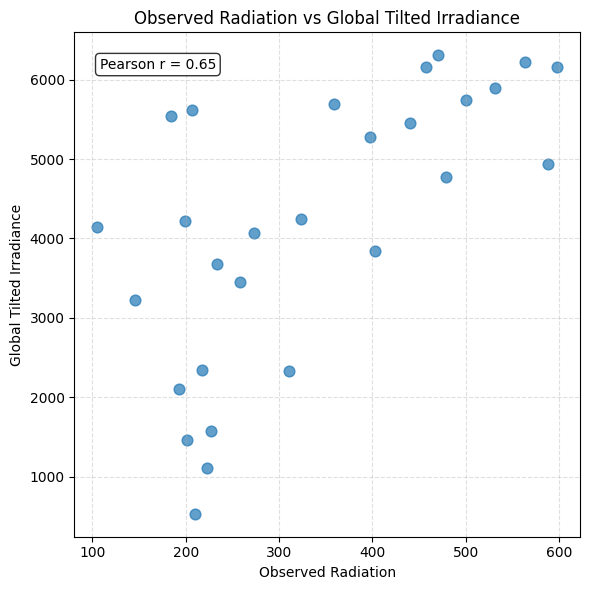

Saved plots to solar_radiation_analysis.pdf


In [8]:
metrics = [col for col in merged_df.columns if col not in ("time", "radiation_observed")]
pdf_path = "solar_radiation_analysis.pdf"

with PdfPages(pdf_path) as pdf:
    for metric in metrics:
        fig, ax_metric = plt.subplots(figsize=(10, 4))
        ax_metric.plot(merged_df["time"], merged_df[metric], marker="o", linewidth=2, label=metric.replace('_', ' ').title())
        ax_metric.set_title(f"Daily {metric.replace('_', ' ').title()} vs Time")
        ax_metric.set_xlabel("Date")
        ax_metric.set_ylabel(metric.replace('_', ' ').title())
        ax_metric.grid(True, linestyle="--", alpha=0.5)

        ax_rad = ax_metric.twinx()
        ax_rad.plot(merged_df["time"], merged_df["radiation_observed"], color="tab:red", linewidth=1.8, linestyle="--", marker="s", label="Observed Radiation")
        ax_rad.set_ylabel("Observed Radiation")

        lines, labels = ax_metric.get_legend_handles_labels()
        lines2, labels2 = ax_rad.get_legend_handles_labels()
        ax_metric.legend(lines + lines2, labels + labels2, loc="upper right")

        fig.tight_layout()
        pdf.savefig(fig)
        plt.show()

    for metric in metrics:
        scatter_data = merged_df[["radiation_observed", metric]].dropna()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(scatter_data["radiation_observed"], scatter_data[metric], s=60, alpha=0.7)
        ax.set_title(f"Observed Radiation vs {metric.replace('_', ' ').title()}")
        ax.set_xlabel("Observed Radiation")
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.grid(True, linestyle="--", alpha=0.4)

        if not scatter_data.empty:
            corr = scatter_data.corr().iloc[0, 1]
            ax.text(0.05, 0.95, f"Pearson r = {corr:.2f}", transform=ax.transAxes, ha="left", va="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
        else:
            ax.text(0.5, 0.5, "No overlapping data", transform=ax.transAxes, ha="center", va="center")

        fig.tight_layout()
        pdf.savefig(fig)
        plt.show()

print(f"Saved plots to {pdf_path}")

In [ ]:
analysis_targets = ["direct_radiation", "direct_normal_irradiance"]
loss_summary = []
per_day_losses = {}

for metric in analysis_targets:
    subset = merged_df[["time", "radiation_observed", metric]].dropna()
    if subset.empty:
        continue
    diff = subset[metric] - subset["radiation_observed"]
    subset = subset.assign(
        error=diff,
        abs_error=np.abs(diff),
        squared_error=diff ** 2
    )
    nonzero_mask = subset["radiation_observed"] != 0
    mape = np.nan
    if nonzero_mask.any():
        mape = (subset.loc[nonzero_mask, "abs_error"] / subset.loc[nonzero_mask, "radiation_observed"]).mean() * 100
    mse = subset["squared_error"].mean()
    mae = subset["abs_error"].mean()
    rmse = np.sqrt(mse)
    loss_summary.append({
        "metric": metric,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape_percent": mape
    })
    per_day_losses[metric] = subset[["time", metric, "radiation_observed", "error", "abs_error", "squared_error"]]

summary_df = pd.DataFrame(loss_summary)
display(summary_df)

for metric, table in per_day_losses.items():
    print(f"\nPer-day loss details for {metric}:")
    display(table)

,metric,mae,mse,rmse,mape_percent
0,direct_radiation,2255.916071,7.622083e+06,2760.812024,700.562341
1,direct_normal_irradiance,3524.741071,1.848064e+07,4298.911600,1095.617843



Per-day loss details for direct_radiation:


,time,direct_radiation,radiation_observed,error,abs_error,squared_error
0,2025-11-01,4667.0,563.45,4103.55,4103.55,1.683912e+07
1,2025-11-02,5179.0,469.90,4709.10,4709.10,2.217562e+07
2,2025-11-03,4848.0,597.81,4250.19,4250.19,1.806412e+07
3,2025-11-04,4869.0,456.97,4412.03,4412.03,1.946601e+07
4,2025-11-05,4121.0,358.37,3762.63,3762.63,1.415738e+07
5,2025-11-06,3095.0,587.92,2507.08,2507.08,6.285450e+06
6,2025-11-07,2008.0,323.86,1684.14,1684.14,2.836328e+06
7,2025-11-08,3887.0,440.45,3446.55,3446.55,1.187871e+07
8,2025-11-09,4094.0,184.08,3909.92,3909.92,1.528747e+07
9,2025-11-10,3940.0,397.36,3542.64,3542.64,1.255030e+07



Per-day loss details for direct_normal_irradiance:


,time,direct_normal_irradiance,radiation_observed,error,abs_error,squared_error
0,2025-11-01,7101.4,563.45,6537.95,6537.95,4.274479e+07
1,2025-11-02,7799.9,469.90,7330.00,7330.00,5.372890e+07
2,2025-11-03,7323.5,597.81,6725.69,6725.69,4.523491e+07
3,2025-11-04,7218.3,456.97,6761.33,6761.33,4.571558e+07
4,2025-11-05,5862.5,358.37,5504.13,5504.13,3.029545e+07
5,2025-11-06,4411.6,587.92,3823.68,3823.68,1.462053e+07
6,2025-11-07,3271.0,323.86,2947.14,2947.14,8.685634e+06
7,2025-11-08,5620.7,440.45,5180.25,5180.25,2.683499e+07
8,2025-11-09,5875.7,184.08,5691.62,5691.62,3.239454e+07
9,2025-11-10,5626.5,397.36,5229.14,5229.14,2.734391e+07


: 